##**Project Description**

This mini-project will solve a problem with generating images of natural landscape paints by developing a generative deep learning solution that can intelligently produce these images without any human intervention. To introduce the problem of Generative Painting, this problem is mainly about yielding paint images of natural landscapes. The mini-project's methodology contains a deep learning solution that will consist of the following steps: Importing Machine Learning/Deep Learning Libraries, Data Collection and Pre-Processing, Exploratory Data Analysis (EDA), Deep Learning Model Building and Architecture, Training-and-Testing Data Split, Feature Engineering, Prediction, Performance Evaluation, and Conclusion. Finally, this mini-project will be submitted for peer-review upon its completion.

##**Import Libraries/Frameworks**

In [1]:
!pip3 install kaggle scikit-learn numpy pandas matplotlib nltk seaborn tensorflow scikit-learn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import string
import os
from google.colab import files
import zipfile
import cv2
import random
import pickle
import shutil

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nezarhindi","key":"3f9a7fb5a85d93a657245e230d84a65d"}'}

In [4]:
# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions to avoid warnings
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle competitions download -c gan-getting-started

 97% 357M/367M [00:03<00:00, 125MB/s]
100% 367M/367M [00:03<00:00, 118MB/s]


In [6]:
print(os.listdir())

# Unzip the dataset
with zipfile.ZipFile("gan-getting-started.zip", "r") as zip_ref:
    zip_ref.extractall("gan-getting-started")

# Verify extraction
os.listdir("gan-getting-started")

['.config', 'gan-getting-started.zip', 'sample_data']


['photo_tfrec', 'monet_jpg', 'monet_tfrec', 'photo_jpg']

##**Exploratory Data Analysis (EDA)**

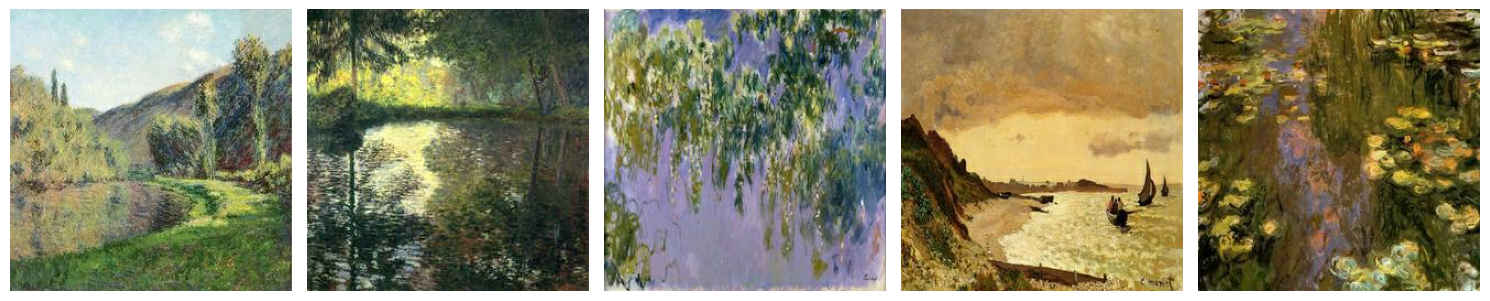

In [7]:
# Load a few sample Monet images
monet_images_path = "./gan-getting-started/monet_jpg/*.jpg"  # Update with actual path
monet_images = glob(monet_images_path)

# Display a few Monet paintings
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_path in enumerate(monet_images[:5]):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

       Width  Height
count  300.0   300.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


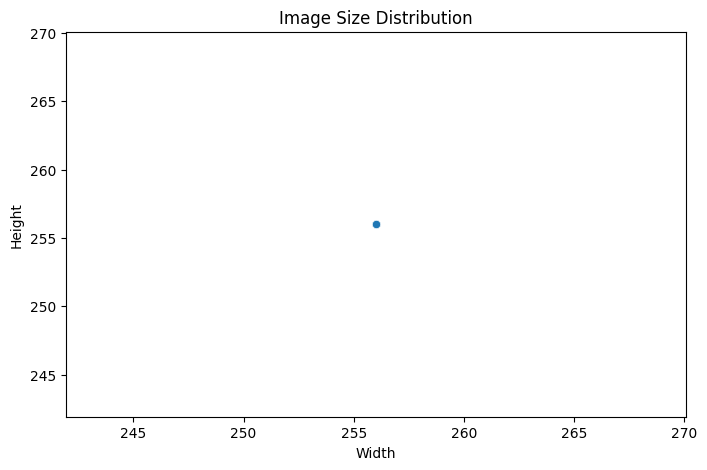

In [8]:
# Check image sizes
image_shapes = [Image.open(img).size for img in monet_images]
image_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Display summary statistics
print(image_df.describe())

# Plot distribution of image sizes
plt.figure(figsize=(8, 5))
sns.scatterplot(x=image_df["Width"], y=image_df["Height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

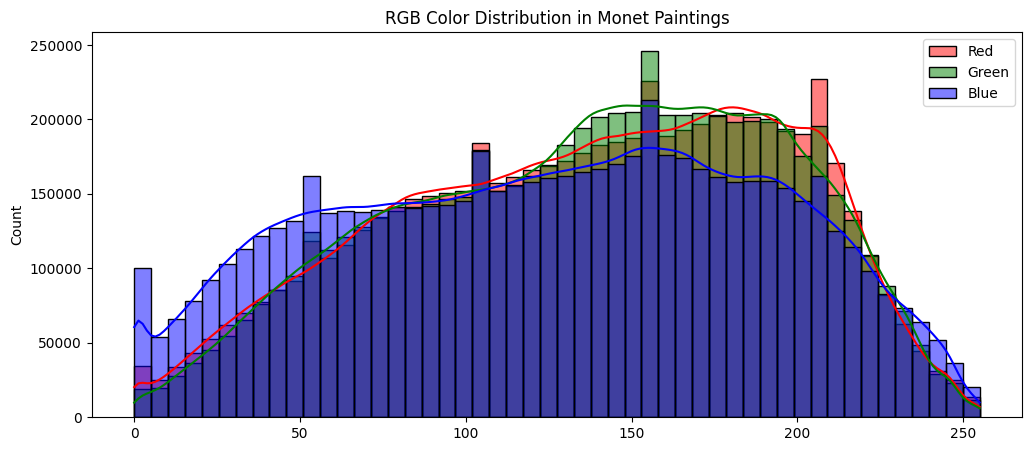

In [9]:
def plot_rgb_distribution(images):
    r_vals, g_vals, b_vals = [], [], []

    for img_path in images[:100]:  # Limit to 100 images for efficiency
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r_vals.extend(img[:, :, 0].flatten())
        g_vals.extend(img[:, :, 1].flatten())
        b_vals.extend(img[:, :, 2].flatten())

    plt.figure(figsize=(12, 5))
    sns.histplot(r_vals, color="red", bins=50, kde=True, label="Red")
    sns.histplot(g_vals, color="green", bins=50, kde=True, label="Green")
    sns.histplot(b_vals, color="blue", bins=50, kde=True, label="Blue")
    plt.legend()
    plt.title("RGB Color Distribution in Monet Paintings")
    plt.show()

# Run the function
plot_rgb_distribution(monet_images)

In [10]:
def check_corrupt_images(image_paths):
    corrupt_count = 0
    for img_path in image_paths:
        try:
            img = Image.open(img_path)
            img.verify()  # Verify image integrity
        except (IOError, SyntaxError) as e:
            corrupt_count += 1
            print(f"Corrupt image: {img_path}")
    print(f"Total corrupt images: {corrupt_count}")

# Check Monet images
check_corrupt_images(monet_images)

Total corrupt images: 0


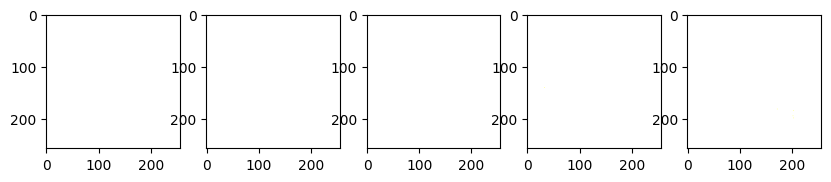

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Display augmented images
sample_img = Image.open(monet_images[0])
sample_img = np.array(sample_img)

plt.figure(figsize=(10, 5))
for i in range(5):
    augmented_img = datagen.random_transform(sample_img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_img)
    plt.axis("on")
plt.show()

##**GAN Model Analysis, Building, and Training**

In [12]:
# Load dataset
monet_images_path = glob(monet_images_path)  # Update with actual path
print(f"Total Monet Images: {len(monet_images_path)}")

Total Monet Images: 300


In [13]:
IMG_SIZE = 256

def load_image(img_path):
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 127.5 - 1  # Normalize to [-1, 1]
    return img

# Load all Monet images
monet_images = np.array([load_image(img) for img in monet_images_path])
print("Dataset Shape:", monet_images.shape)

Dataset Shape: (300, 256, 256, 3)


In [14]:
def build_generator():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    x = Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(inputs)
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)

    # Residual Blocks
    for _ in range(6):
        res = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
        res = Conv2D(128, (3, 3), padding="same")(res)
        x = Add()([x, res])  # Skip connection

    # Decoder
    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(3, (3, 3), strides=2, padding="same", activation="tanh")(x)

    return Model(inputs, x, name="Generator")

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 128)    │              0 │ add[0][0],             │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64, 128)    │              0 │ add_1[0][0],           │
│                           │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 64, 64, 128)    │              0 │ add_2[0][0],           │
│                           │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)          

 Total params: 1,922,179 (7.33 MB)

 Trainable params: 1,922,179 (7.33 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def build_discriminator():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(inputs)
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)  # Output probability

    return Model(inputs, x, name="Discriminator")

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         524,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 599,937 (2.29 MB)

 Trainable params: 599,937 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss_fn)
def train_gan(generator, discriminator, dataset, epochs=100, batch_size=32):
    for epoch in range(epochs):
        for i in range(0, len(dataset), batch_size):
            real_images = dataset[i:i+batch_size]
            fake_images = generator.predict(real_images)

            # Labels: Real images -> 1, Fake images -> 0
            real_labels = np.ones((len(real_images), 1))
            fake_labels = np.zeros((len(fake_images), 1))

            # Train Discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train Generator
            misleading_labels = np.ones((len(fake_images), 1))  # Trick discriminator
            g_loss = discriminator.train_on_batch(fake_images, misleading_labels)

        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss:.4f} - G Loss: {g_loss:.4f}")

# Train the GAN
train_gan(generator, discriminator, monet_images, epochs=100, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1/100 - D Loss: 0.5146 - G Loss: 0.5187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 2/100 - D Loss: 0.4900 - G Loss: 0.4920
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━

In [17]:
def generate_images(generator, num_images=7000, save_path="generated_monet/"):
    os.makedirs(save_path, exist_ok=True)

    for i in range(num_images):
        noise = np.random.randn(1, IMG_SIZE, IMG_SIZE, 3)  # Random noise input
        generated_img = generator.predict(noise)[0]  # Generate single image
        generated_img = (generated_img + 1) * 127.5  # Rescale to [0, 255]
        Image.fromarray(generated_img.astype("uint8")).save(f"{save_path}/monet_{i}.jpg")
        print(f"{i}th image")

    print(f"Generated {num_images} Monet-style images!")

# Generate images
generate_images(generator, num_images=7000)

Streaming output truncated to the last 5000 lines.
4500th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4501th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4502th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4503th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4504th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4505th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4506th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4507th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4508th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4509th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4510th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4511th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4512th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4513th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4514th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4515th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4516th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4517th image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4518th image
1/1 ━━━━━━━━━━━━━━

In [18]:
# Load real Monet images for testing
generated_monet_images_path = glob("./generated_monet/*.jpg")  # Path to GAN-generated Monet images

# Define the folder containing generated images
output_folder = "generated_monet"  # Update with actual folder path

# Define the output zip file name
zip_filename = "images.zip"

# Create a zip archive of the generated images folder
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', output_folder)

print(f"ZIP file '{zip_filename}' created successfully!")

ZIP file 'images.zip' created successfully!


In [ ]:
def preprocess_image(img_path):
    img = Image.open(img_path).resize((256, 256))
    img = np.array(img) / 127.5 - 1  # Normalize to [-1, 1]
    return img

# Prepare test datasets
real_monet_images = np.array([preprocess_image(img) for img in monet_images_path])
fake_monet_images = np.array([preprocess_image(img) for img in generated_monet_images_path])

# Labels: 1 for real Monet paintings, 0 for generated images
real_labels = np.ones((len(real_monet_images), 1))
fake_labels = np.zeros((len(fake_monet_images), 1))

In [ ]:
# Predict using the discriminator
real_predictions = discriminator.predict(real_monet_images)
fake_predictions = discriminator.predict(fake_monet_images)

# Convert probabilities to binary labels (Threshold = 0.5)
real_pred_labels = (real_predictions > 0.5).astype(int)
fake_pred_labels = (fake_predictions > 0.5).astype(int)

# Combine results
y_true = np.vstack((real_labels, fake_labels))  # Ground truth labels
y_pred = np.vstack((real_pred_labels, fake_pred_labels))  # Predicted labels

In [ ]:
# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Discriminator Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Generated", "Real"], yticklabels=["Generated", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

##**Discussion**

##**Conclusion**